# Find Tickers
We would like to identify cointegrated pairs.


In this example we will look at Utilities. The flow of this file is as follows

1. Read the tickers from the list we made
2. Look at only those where volume is greater than 1000000 for high liquidity
3. Drop missing values
4. Perform coint test and get those with p_value less than 0.05 


In [40]:
import json
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.stattools import coint

In [41]:
filename='data/utilities.csv'
df = pd.read_csv(filename, index_col = 0)
df.head()

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,INTC,Intel Corporation,36.34,-1.65,-4.34%,53.18M,38.242M,152.192B,NaN,NaN
1,AAPL,Apple Inc.,179.07,1.10,+0.62%,50.448M,57.543M,2.8T,30.05,NaN
2,AMD,"Advanced Micro Devices, Inc.",101.61,-0.76,-0.74%,41.536M,61.521M,164.168B,NaN,NaN
3,NVDA,NVIDIA Corporation,435.20,-4.46,-1.01%,37.136M,49.922M,1.075T,105.38,NaN
4,PLTR,Palantir Technologies Inc.,15.15,-0.31,-2.01%,37.498M,63.544M,32.6B,NaN,NaN


In [42]:
df.shape

(100, 10)

We want to trade with stocks with adequate demand from buyers and sellers, we can eliminate others by defining a cap for the trade volume.

In [43]:
def convert_volume(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6  # Convert to millions
    elif 'k' in value:
        return float(value.replace('k', '')) * 1e3  # Convert to thousands
    else:
        return float(value)  # No conversion needed

# Apply the conversion function to the 'Volume' column
df['Volume'] = df['Volume'].apply(convert_volume)

In [44]:
 # Define a volume cap
volume_cap = 1000000

df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
df['Price (Intraday)'] = pd.to_numeric(df['Price (Intraday)'], errors='coerce')

df = df[['Symbol','Volume','Price (Intraday)']].sort_values(by='Volume', ascending=False)

tickers = df[df["Volume"]>volume_cap].Symbol.tolist()

tickers

['INTC',
 'AAPL',
 'AMD',
 'PLTR',
 'NVDA',
 'GRAB',
 'UBER',
 'ARM',
 'SQ',
 'MSFT',
 'NOK',
 'SHOP',
 'U',
 'CSCO',
 'MU',
 'ORCL',
 'FIS',
 'HPQ',
 'HPE',
 'ZI',
 'TSM',
 'MRVL',
 'AMAT',
 'TOST',
 'APP',
 'UMC',
 'ENPH',
 'QCOM',
 'IOT',
 'FTNT',
 'TTD',
 'ASX',
 'SNOW',
 'CTSH',
 'ADYEY',
 'ERIC',
 'DELL',
 'NET',
 'IBM',
 'GLW',
 'CRM',
 'INFY',
 'WDC',
 'ON',
 'TXN',
 'PANW',
 'ADI',
 'DIDIY',
 'STM',
 'STX',
 'PSTG',
 'DT',
 'ZM',
 'ADBE',
 'CRWD',
 'AKAM',
 'MCHP',
 'GDDY',
 'SMCI',
 'DDOG',
 'TER',
 'FTV',
 'FLEX',
 'ACN',
 'OKTA',
 'GEN',
 'BILL',
 'ZS',
 'FSLR',
 'VMW',
 'LSCC',
 'NTAP',
 'GFS',
 'CDAY',
 'AVGO',
 'ENTG',
 'SWKS',
 'NXPI',
 'APH',
 'KEYS',
 'ADSK',
 'WDAY',
 'FI',
 'SPLK',
 'LRCX',
 'ANET',
 'INTU',
 'TRMB',
 'BSY']

### Download Price Data
We will use yfinance (https://pypi.org/project/yfinance/) to downloed the closing prices of stocks.
More information is available on the next notebook which we will download and save a more detailed stock data.

In [45]:
#!pip install <library_name>
#period = '1y' #valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
#interval = '1d' #valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#df = yf.download(tickers, period=period, interval=interval)["Close"]


# Enable to use start & end dates:
start = datetime.date.today() - datetime.timedelta(days=430)
end = datetime.date.today() - datetime.timedelta(days=60)

df = yf.download(tickers, start, end)["Close"]

df.info()
len(df)

[*********************100%%**********************]  89 of 89 completed


1 Failed download:
['ARM']: Exception("%ticker%: Data doesn't exist for startDate = 1658721600, endDate = 1690689600")



<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 2022-07-25 00:00:00 to 2023-07-28 00:00:00
Data columns (total 89 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    255 non-null    float64
 1   ACN     255 non-null    float64
 2   ADBE    255 non-null    float64
 3   ADI     255 non-null    float64
 4   ADSK    255 non-null    float64
 5   ADYEY   255 non-null    float64
 6   AKAM    255 non-null    float64
 7   AMAT    255 non-null    float64
 8   AMD     255 non-null    float64
 9   ANET    255 non-null    float64
 10  APH     255 non-null    float64
 11  APP     255 non-null    float64
 12  ARM     0 non-null      float64
 13  ASX     255 non-null    float64
 14  AVGO    255 non-null    float64
 15  BILL    255 non-null    float64
 16  BSY     255 non-null    float64
 17  CDAY    255 non-null    float64
 18  CRM     255 non-null    float64
 19  CRWD    255 non-null    float64
 20  CSCO    255 non-null    float64
 21  CTSH    2

255

Check for null values and eliminate them
It is important to check the dataframe for Na rows & columns before moving forward. Downloaded data may not be consistent all the time, so better doing it manually before proceeding:


In [46]:
df.head()

,AAPL,ACN,ADBE,ADI,ADSK,ADYEY,AKAM,AMAT,AMD,ANET,...,TXN,U,UBER,UMC,VMW,WDAY,WDC,ZI,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-25 00:00:00,152.949997,289.290009,391.959991,163.039993,195.710007,17.000000,92.690002,101.000000,87.540001,103.459999,...,163.199997,35.540001,23.350000,6.87,113.470001,145.440002,46.840000,37.099998,106.099998,156.089996
2022-07-26 00:00:00,151.600006,285.179993,379.260010,161.779999,193.070007,15.760000,92.150002,98.910004,85.250000,103.339996,...,160.839996,33.520000,22.549999,6.49,113.449997,140.910004,46.950001,35.450001,100.330002,141.949997
2022-07-27 00:00:00,156.789993,297.529999,392.779999,168.330002,203.410004,17.200001,93.650002,103.459999,89.820000,109.099998,...,171.539993,37.220001,23.090000,6.89,115.730003,150.100006,48.430000,37.049999,105.910004,148.710007
2022-07-28 00:00:00,157.350006,303.679993,403.500000,169.669998,212.160004,17.559999,94.580002,105.160004,91.669998,115.330002,...,175.750000,37.570000,23.309999,6.72,116.360001,152.809998,48.720001,37.520000,106.220001,153.059998
2022-07-29 00:00:00,162.509995,306.260010,410.119995,171.960007,216.320007,18.020000,96.220001,105.980003,94.470001,116.629997,...,178.889999,37.389999,23.450001,6.82,116.199997,155.100006,49.099998,37.889999,103.860001,155.059998


In [47]:
df = df.dropna(axis=0, how='all') # drop rows whose values are all NA
df = df.dropna(axis=1) 
new_tickers = df.columns.tolist()
print(f"we have {len(new_tickers)} tickers left")
file_name = "data/utilities_close_prices.pkl"
df.to_pickle(file_name)
df.info()

we have 88 tickers left
<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 2022-07-25 00:00:00 to 2023-07-28 00:00:00
Data columns (total 88 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    255 non-null    float64
 1   ACN     255 non-null    float64
 2   ADBE    255 non-null    float64
 3   ADI     255 non-null    float64
 4   ADSK    255 non-null    float64
 5   ADYEY   255 non-null    float64
 6   AKAM    255 non-null    float64
 7   AMAT    255 non-null    float64
 8   AMD     255 non-null    float64
 9   ANET    255 non-null    float64
 10  APH     255 non-null    float64
 11  APP     255 non-null    float64
 12  ASX     255 non-null    float64
 13  AVGO    255 non-null    float64
 14  BILL    255 non-null    float64
 15  BSY     255 non-null    float64
 16  CDAY    255 non-null    float64
 17  CRM     255 non-null    float64
 18  CRWD    255 non-null    float64
 19  CSCO    255 non-null    float64
 20  CTSH    255 non-null   

### Find Cointegrated Pairs

We will perfom cointegration tests for all of the pairs that we can produce from the available tickers. We still need to perform more detailed tests for stationarity in the following notebooks.

This function is designed to perform a statistical test called a cointegration test on a set of financial data, which typically represents the price movements of different assets or financial instruments (often referred to as "tickers"). Let me break down what this function does step by step:

`def cointegration_test(data, p_value=0.05)`:: This line defines a Python function called cointegration_test that takes two inputs: `data` and `p_value`. `data` is expected to be a dataset containing historical price or return data for multiple financial instruments (tickers), and `p_value` is a significance level used in the test, with a default value of 0.05 (commonly used in statistical testing).

`n = data.shape[1]`: This line calculates the number of columns (or financial instruments) in the input dataset data and assigns it to the variable n.

`stats = np.zeros((n, n))` and `pvalues = np.ones((n, n))`: These lines create two empty matrices (`stats` and `pvalues`) with dimensions n by n, where n is the number of financial instruments. These matrices will be filled with statistical results later.

`keys = data.keys()`: This line retrieves the names of the columns (financial instruments) in the input dataset and stores them in the keys variable.

`pairs = []`: This initializes an empty list called `pairs`. This list will store pairs of financial instruments that show significant cointegration.

The following nested for loops iterate through all possible combinations of financial instruments (tickers):

`for i in range(n)`:: This loop selects one financial instrument (ticker) as the first in a pair.
`for j in range(i+1, n)`:: This nested loop selects a different financial instrument as the second in a pair. The use of i+1 ensures that each pair is unique (e.g., it won't consider the same pair twice).
`result = coint(data[keys[i]], data[keys[j]])`: For each pair of financial instruments selected in the loops, this line calculates the cointegration test statistics and p-value using a function called `coint`. It compares the historical price or return data of the two instruments to see if they are cointegrated.

`test_stat = result[0] and pvalue = result[1]`: These lines extract the test statistic and p-value from the result of the cointegration test.

`stats[i, j] = test_stat and pvalues[i, j] = pvalue`: These lines store the test statistic and p-value in the corresponding positions in the stats and pvalues matrices.

`if pvalue < p_value:`: This line checks if the calculated p-value is less than the significance level (`p_value`). If it is, it means that the pair of financial instruments is statistically significant in terms of cointegration.

`pairs.append((keys[i], keys[j])):` If the pair is statistically significant, it is added to the pairs list, which keeps track of all such pairs.

Finally, the function returns three things:

`stats`: A matrix containing the cointegration test statistics for all pairs of financial instruments.
`pvalues`: A matrix containing the p-values for the cointegration test for all pairs.
`pairs`: A list of pairs of financial instruments that are statistically significant in terms of cointegration.
In summary, this function automates the process of testing whether pairs of financial instruments (tickers) are cointegrated, which can be useful for various quantitative trading and portfolio management strategies in finance. It collects and organizes the statistical results, making it easier for analysts and traders to identify pairs of assets that exhibit cointegration and may be suitable for trading strategies like pairs trading.

In [48]:
# let's define a function to loop through the tickers and do a cointegration test for each combination
def cointegration_test(data, p_value_thres=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue

            if pvalue < p_value_thres: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))

    return stats, pvalues, pairs

[('AAPL', 'TTD'), ('ACN', 'ADYEY'), ('ACN', 'DELL'), ('ACN', 'HPQ'), ('ACN', 'INTC'), ('ADBE', 'FTV'), ('ADBE', 'INTU'), ('ADI', 'CSCO'), ('ADI', 'LSCC'), ('ADSK', 'ADYEY'), ('ADSK', 'AMAT'), ('ADSK', 'APH'), ('ADSK', 'BILL'), ('ADSK', 'BSY'), ('ADSK', 'CRM'), ('ADSK', 'CRWD'), ('ADSK', 'CTSH'), ('ADSK', 'DDOG'), ('ADSK', 'ENTG'), ('ADSK', 'FIS'), ('ADSK', 'FTNT'), ('ADSK', 'FTV'), ('ADSK', 'GDDY'), ('ADSK', 'GLW'), ('ADSK', 'GRAB'), ('ADSK', 'HPE'), ('ADSK', 'HPQ'), ('ADSK', 'IBM'), ('ADSK', 'INTC'), ('ADSK', 'KEYS'), ('ADSK', 'LRCX'), ('ADSK', 'MCHP'), ('ADSK', 'MRVL'), ('ADSK', 'NET'), ('ADSK', 'PLTR'), ('ADSK', 'QCOM'), ('ADSK', 'SHOP'), ('ADSK', 'SPLK'), ('ADSK', 'SQ'), ('ADSK', 'STX'), ('ADSK', 'SWKS'), ('ADSK', 'TOST'), ('ADSK', 'TRMB'), ('ADSK', 'TTD'), ('ADSK', 'TXN'), ('ADSK', 'U'), ('ADSK', 'WDAY'), ('ADSK', 'WDC'), ('ADSK', 'ZI'), ('ADSK', 'ZM'), ('ADSK', 'ZS'), ('ADYEY', 'AMD'), ('ADYEY', 'APH'), ('ADYEY', 'BSY'), ('ADYEY', 'DELL'), ('ADYEY', 'FTV'), ('ADYEY', 'HPQ'), ('AD

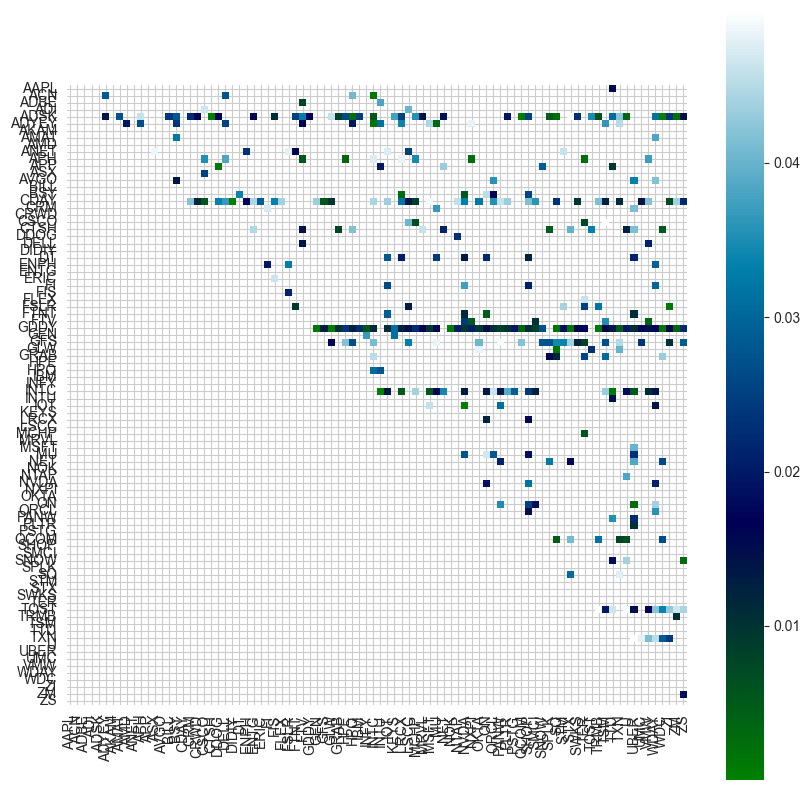

In [49]:
p_value_thres = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs = cointegration_test(df,p_value_thres)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    pvalues,
    xticklabels=new_tickers,
    yticklabels=new_tickers,
    cmap="ocean",
    mask=(pvalues >= p_value_thres),
    square=True
)
print(pairs)

### Filter For More Significant Pairs
Filter more to get more significant pairs, and eliminate empty cells.

after masked
      AAPL  ACN  ADBE  ADI  ADSK     ADYEY  AKAM      AMAT  AMD  ANET  ...  \
AAPL   NaN  NaN   NaN  NaN   NaN       NaN   NaN       NaN  NaN   NaN  ...   
ACN    NaN  NaN   NaN  NaN   NaN  0.028476   NaN       NaN  NaN   NaN  ...   
ADBE   NaN  NaN   NaN  NaN   NaN       NaN   NaN       NaN  NaN   NaN  ...   
ADI    NaN  NaN   NaN  NaN   NaN       NaN   NaN       NaN  NaN   NaN  ...   
ADSK   NaN  NaN   NaN  NaN   NaN  0.013436   NaN  0.027457  NaN   NaN  ...   
...    ...  ...   ...  ...   ...       ...   ...       ...  ...   ...  ...   
WDAY   NaN  NaN   NaN  NaN   NaN       NaN   NaN       NaN  NaN   NaN  ...   
WDC    NaN  NaN   NaN  NaN   NaN       NaN   NaN       NaN  NaN   NaN  ...   
ZI     NaN  NaN   NaN  NaN   NaN       NaN   NaN       NaN  NaN   NaN  ...   
ZM     NaN  NaN   NaN  NaN   NaN       NaN   NaN       NaN  NaN   NaN  ...   
ZS     NaN  NaN   NaN  NaN   NaN       NaN   NaN       NaN  NaN   NaN  ...   

           TXN         U  UBER  UMC  VMW     WDAY 

,ADYEY,AMAT,AMD,APH,ASX,BILL,BSY,CRM,CRWD,CSCO,CTSH,DDOG,DELL,DIDIY,DT,ENPH,ENTG,ERIC,FI,FIS,FLEX,FSLR,FTNT,FTV,GDDY,GEN,GFS,GLW,GRAB,HPE,HPQ,IBM,INFY,INTC,INTU,IOT,KEYS,LRCX,LSCC,MCHP,MRVL,MSFT,MU,NET,NOK,NTAP,NVDA,NXPI,OKTA,ON,ORCL,PANW,PLTR,PSTG,QCOM,SHOP,SMCI,SNOW,SPLK,SQ,STM,STX,SWKS,TER,TOST,TRMB,TSM,TTD,TXN,U,UBER,UMC,VMW,WDAY,WDC,ZI,ZM,ZS
AAPL,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.016,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ACN,0.028,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.027,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.041,nan,nan,0.001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ADBE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.008,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.038,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ADI,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.046,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.040,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ADSK,0.013,0.027,nan,0.046,nan,0.024,0.028,0.022,0.016,nan,0.000,0.017,nan,nan,nan,nan,0.016,nan,nan,0.011,nan,nan,0.025,0.033,0.017,nan,nan,0.046,0.009,0.026,0.002,0.025,nan,0.005,nan,nan,0.038,0.025,nan,0.036,0.014,nan,nan,0.019,nan,nan,nan,nan,nan,nan,nan,nan,0.019,nan,0.000,0.025,nan,nan,0.005,0.002,nan,0.049,0.023,nan,0.035,0.006,nan,0.031,0.042,0.004,nan,nan,nan,0.032,0.000,0.024,0.002,0.015
ADYEY,nan,nan,0.020,0.027,nan,nan,0.024,nan,nan,nan,nan,nan,0.025,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.016,nan,nan,nan,nan,nan,nan,0.020,nan,nan,0.001,0.031,nan,nan,0.034,nan,nan,nan,0.045,0.003,nan,nan,nan,nan,0.048,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.036,nan,0.045,nan,nan,nan,nan,nan,nan,nan,nan,nan
AMAT,nan,nan,nan,nan,nan,nan,0.032,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.038,nan,nan,nan,nan
ANET,nan,nan,nan,nan,0.049,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.023,nan,nan,nan,nan,nan,0.048,0.016,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.047,nan,nan,0.025,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.046,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
APH,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.035,nan,nan,0.038,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.006,nan,nan,nan,nan,nan,0.004,nan,nan,nan,0.048,nan,nan,nan,0.048,nan,0.035,nan,nan,nan,nan,nan,nan,nan,0.002,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.002,nan,nan,nan,nan,nan,nan,nan,nan,0.037,nan,nan,nan,nan,nan
APP,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.020,nan,nan,nan,nan,nan,nan,nan,nan,0.043,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.029,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.009,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


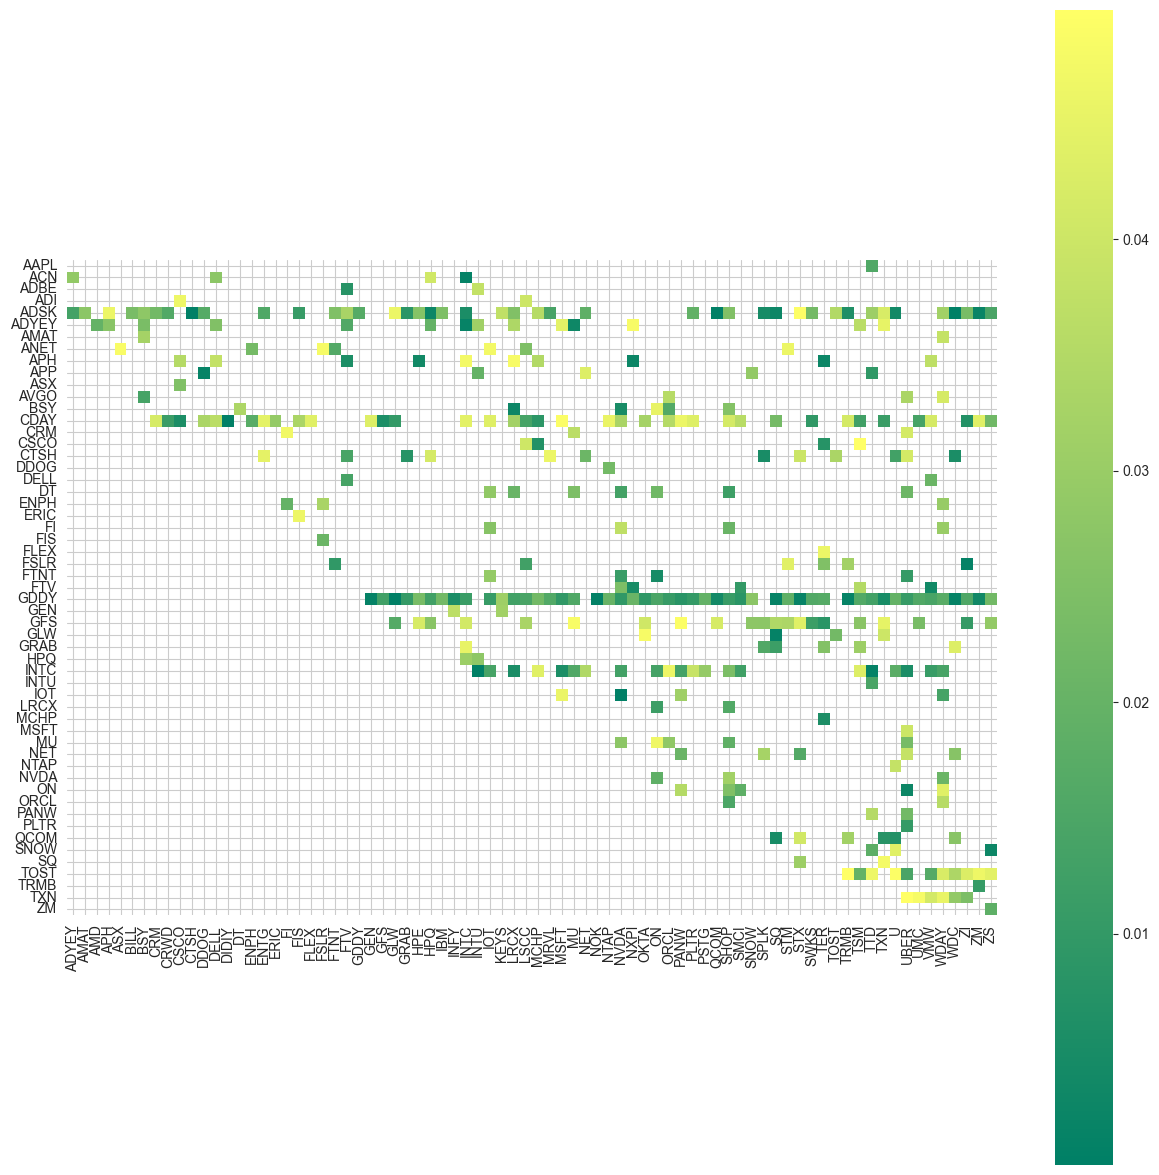

In [50]:
mask_matrix = (pvalues >= p_value_thres) # possible to increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= new_tickers, columns = new_tickers)
scores_df = pd.DataFrame(scores, index= new_tickers, columns = new_tickers)
pvalues_df = pd.DataFrame(pvalues, index= new_tickers, columns = new_tickers)

print('after masked')
print(pvalues_df[~mask_df])
df_f = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_f = df_f.dropna(how='all')

def gold_apply(x):
    color = {True: "background-color: #c78f2e", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color


fig, ax = plt.subplots(figsize=(15, 15))
seaborn.heatmap(
    df_f,
    xticklabels=df_f.columns,
    yticklabels=df_f.index,
    cmap="summer",
    square=True
)
df_f.style.format(precision=3) \
    .apply(gold_apply)

In [51]:
x_list = df_f.index.tolist()
y_list = df_f.columns.tolist()

new_pairs_list = [] # list of pairs as tuples (A,B)

print(df_f)
for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_f.iloc[i,j]>0:
            new_pairs_list.append((x_list[i], y_list[j]))

new_pairs_list

          ADYEY      AMAT       AMD       APH       ASX      BILL       BSY  \
AAPL        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ACN    0.028476       NaN       NaN       NaN       NaN       NaN       NaN   
ADBE        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ADI         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ADSK   0.013436  0.027457       NaN  0.046037       NaN  0.023613  0.027768   
ADYEY       NaN       NaN  0.019648  0.026896       NaN       NaN  0.023862   
AMAT        NaN       NaN       NaN       NaN       NaN       NaN  0.032253   
ANET        NaN       NaN       NaN       NaN  0.048667       NaN       NaN   
APH         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
APP         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ASX         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
AVGO        NaN       NaN       NaN       NaN       

[('AAPL', 'TTD'),
 ('ACN', 'ADYEY'),
 ('ACN', 'DELL'),
 ('ACN', 'HPQ'),
 ('ACN', 'INTC'),
 ('ADBE', 'FTV'),
 ('ADBE', 'INTU'),
 ('ADI', 'CSCO'),
 ('ADI', 'LSCC'),
 ('ADSK', 'ADYEY'),
 ('ADSK', 'AMAT'),
 ('ADSK', 'APH'),
 ('ADSK', 'BILL'),
 ('ADSK', 'BSY'),
 ('ADSK', 'CRM'),
 ('ADSK', 'CRWD'),
 ('ADSK', 'CTSH'),
 ('ADSK', 'DDOG'),
 ('ADSK', 'ENTG'),
 ('ADSK', 'FIS'),
 ('ADSK', 'FTNT'),
 ('ADSK', 'FTV'),
 ('ADSK', 'GDDY'),
 ('ADSK', 'GLW'),
 ('ADSK', 'GRAB'),
 ('ADSK', 'HPE'),
 ('ADSK', 'HPQ'),
 ('ADSK', 'IBM'),
 ('ADSK', 'INTC'),
 ('ADSK', 'KEYS'),
 ('ADSK', 'LRCX'),
 ('ADSK', 'MCHP'),
 ('ADSK', 'MRVL'),
 ('ADSK', 'NET'),
 ('ADSK', 'PLTR'),
 ('ADSK', 'QCOM'),
 ('ADSK', 'SHOP'),
 ('ADSK', 'SPLK'),
 ('ADSK', 'SQ'),
 ('ADSK', 'STX'),
 ('ADSK', 'SWKS'),
 ('ADSK', 'TOST'),
 ('ADSK', 'TRMB'),
 ('ADSK', 'TTD'),
 ('ADSK', 'TXN'),
 ('ADSK', 'U'),
 ('ADSK', 'WDAY'),
 ('ADSK', 'WDC'),
 ('ADSK', 'ZI'),
 ('ADSK', 'ZM'),
 ('ADSK', 'ZS'),
 ('ADYEY', 'AMD'),
 ('ADYEY', 'APH'),
 ('ADYEY', 'BSY'),
 ('ADY

In [52]:
new_pairs_str =[] # list of pairs as string A-B

for column in df_f:
    toprint = df_f.index[df_f[column]>0].tolist()
    new_pairs_str.append([column + "-" + s for s in toprint])

new_pairs_str

[['ADYEY-ACN', 'ADYEY-ADSK'],
 ['AMAT-ADSK'],
 ['AMD-ADYEY'],
 ['APH-ADSK', 'APH-ADYEY'],
 ['ASX-ANET'],
 ['BILL-ADSK'],
 ['BSY-ADSK', 'BSY-ADYEY', 'BSY-AMAT', 'BSY-AVGO'],
 ['CRM-ADSK', 'CRM-CDAY'],
 ['CRWD-ADSK', 'CRWD-CDAY'],
 ['CSCO-ADI', 'CSCO-APH', 'CSCO-ASX', 'CSCO-CDAY'],
 ['CTSH-ADSK'],
 ['DDOG-ADSK', 'DDOG-APP', 'DDOG-CDAY'],
 ['DELL-ACN', 'DELL-ADYEY', 'DELL-APH', 'DELL-CDAY'],
 ['DIDIY-CDAY'],
 ['DT-BSY'],
 ['ENPH-ANET', 'ENPH-CDAY'],
 ['ENTG-ADSK', 'ENTG-CDAY', 'ENTG-CTSH'],
 ['ERIC-CDAY'],
 ['FI-CRM', 'FI-ENPH'],
 ['FIS-ADSK', 'FIS-CDAY', 'FIS-ERIC'],
 ['FLEX-CDAY'],
 ['FSLR-ANET', 'FSLR-ENPH', 'FSLR-FIS'],
 ['FTNT-ADSK', 'FTNT-ANET', 'FTNT-FSLR'],
 ['FTV-ADBE', 'FTV-ADSK', 'FTV-ADYEY', 'FTV-APH', 'FTV-CTSH', 'FTV-DELL'],
 ['GDDY-ADSK'],
 ['GEN-CDAY', 'GEN-GDDY'],
 ['GFS-CDAY', 'GFS-GDDY'],
 ['GLW-ADSK', 'GLW-CDAY', 'GLW-GDDY', 'GLW-GFS'],
 ['GRAB-ADSK', 'GRAB-CTSH', 'GRAB-GDDY'],
 ['HPE-ADSK', 'HPE-APH', 'HPE-GDDY', 'HPE-GFS'],
 ['HPQ-ACN', 'HPQ-ADSK', 'HPQ-ADYEY', 'HPQ-

In [53]:
new_pairs_dic= {} # list of pairs as dictionary {'A':['B','C']}

for column in df_f:
    new_pairs_dic[column] = df_f.index[df_f[column]>0].tolist()

new_pairs_dic

{'ADYEY': ['ACN', 'ADSK'],
 'AMAT': ['ADSK'],
 'AMD': ['ADYEY'],
 'APH': ['ADSK', 'ADYEY'],
 'ASX': ['ANET'],
 'BILL': ['ADSK'],
 'BSY': ['ADSK', 'ADYEY', 'AMAT', 'AVGO'],
 'CRM': ['ADSK', 'CDAY'],
 'CRWD': ['ADSK', 'CDAY'],
 'CSCO': ['ADI', 'APH', 'ASX', 'CDAY'],
 'CTSH': ['ADSK'],
 'DDOG': ['ADSK', 'APP', 'CDAY'],
 'DELL': ['ACN', 'ADYEY', 'APH', 'CDAY'],
 'DIDIY': ['CDAY'],
 'DT': ['BSY'],
 'ENPH': ['ANET', 'CDAY'],
 'ENTG': ['ADSK', 'CDAY', 'CTSH'],
 'ERIC': ['CDAY'],
 'FI': ['CRM', 'ENPH'],
 'FIS': ['ADSK', 'CDAY', 'ERIC'],
 'FLEX': ['CDAY'],
 'FSLR': ['ANET', 'ENPH', 'FIS'],
 'FTNT': ['ADSK', 'ANET', 'FSLR'],
 'FTV': ['ADBE', 'ADSK', 'ADYEY', 'APH', 'CTSH', 'DELL'],
 'GDDY': ['ADSK'],
 'GEN': ['CDAY', 'GDDY'],
 'GFS': ['CDAY', 'GDDY'],
 'GLW': ['ADSK', 'CDAY', 'GDDY', 'GFS'],
 'GRAB': ['ADSK', 'CTSH', 'GDDY'],
 'HPE': ['ADSK', 'APH', 'GDDY', 'GFS'],
 'HPQ': ['ACN', 'ADSK', 'ADYEY', 'CTSH', 'GDDY', 'GFS'],
 'IBM': ['ADSK', 'GDDY'],
 'INFY': ['GDDY', 'GEN'],
 'INTC': ['ACN', 'ADSK'

### Save to file
Save dataframa as pickle to use for the next steps

In [54]:
df_f.to_pickle("data/pairs_to_download.pkl")

In [55]:
new_pairs_dic

{'ADYEY': ['ACN', 'ADSK'],
 'AMAT': ['ADSK'],
 'AMD': ['ADYEY'],
 'APH': ['ADSK', 'ADYEY'],
 'ASX': ['ANET'],
 'BILL': ['ADSK'],
 'BSY': ['ADSK', 'ADYEY', 'AMAT', 'AVGO'],
 'CRM': ['ADSK', 'CDAY'],
 'CRWD': ['ADSK', 'CDAY'],
 'CSCO': ['ADI', 'APH', 'ASX', 'CDAY'],
 'CTSH': ['ADSK'],
 'DDOG': ['ADSK', 'APP', 'CDAY'],
 'DELL': ['ACN', 'ADYEY', 'APH', 'CDAY'],
 'DIDIY': ['CDAY'],
 'DT': ['BSY'],
 'ENPH': ['ANET', 'CDAY'],
 'ENTG': ['ADSK', 'CDAY', 'CTSH'],
 'ERIC': ['CDAY'],
 'FI': ['CRM', 'ENPH'],
 'FIS': ['ADSK', 'CDAY', 'ERIC'],
 'FLEX': ['CDAY'],
 'FSLR': ['ANET', 'ENPH', 'FIS'],
 'FTNT': ['ADSK', 'ANET', 'FSLR'],
 'FTV': ['ADBE', 'ADSK', 'ADYEY', 'APH', 'CTSH', 'DELL'],
 'GDDY': ['ADSK'],
 'GEN': ['CDAY', 'GDDY'],
 'GFS': ['CDAY', 'GDDY'],
 'GLW': ['ADSK', 'CDAY', 'GDDY', 'GFS'],
 'GRAB': ['ADSK', 'CTSH', 'GDDY'],
 'HPE': ['ADSK', 'APH', 'GDDY', 'GFS'],
 'HPQ': ['ACN', 'ADSK', 'ADYEY', 'CTSH', 'GDDY', 'GFS'],
 'IBM': ['ADSK', 'GDDY'],
 'INFY': ['GDDY', 'GEN'],
 'INTC': ['ACN', 'ADSK'

In [58]:
# Define the file path
file_path = "data/pairs_names.json"

# Save the dictionary to the JSON file
with open(file_path, "w") as json_file:
    json.dump(new_pairs_dic, json_file)